# ÏÉùÏÑ±Ìòï AIÏôÄ Fault Detection
Í≥µÏ†ïÏãúÏä§ÌÖú Ïó¨Î¶ÑÌïôÍµê Module C: Í≥µÏ†ïÏãúÏä§ÌÖúÏùÑ ÏúÑÌïú Ïù∏Í≥µÏßÄÎä•

Session 2-2: ÏÉùÏÑ±Ìòï AIÏôÄ Fault Detection

2025ÎÖÑ 8Ïõî 21Ïùº (Î™©) 08:30 - 12:30

Ïù∏Ï≤úÎåÄÌïôÍµê ÏóêÎÑàÏßÄÌôîÌïôÍ≥µÌïôÍ≥º ÍπÄÏ¢ÖÏö∞

In [1]:
!python -m pip install --upgrade pip
!python -m pip install "numpy<2" scipy matplotlib
!python -m pip install casadi==3.6.5
!python -m pip install torch
!python -m pip install scikit-learn

In [2]:
import os
import sys
import time
import math
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KernelDensity
import seaborn as sns

KDE Í∏∞Î∞ò ÏÉÅÏúÑ Œ±% UCL Í≥ÑÏÇ∞ (`compute_KDE`)

ÏûÖÎ†• Îç∞Ïù¥ÌÑ∞(Îã®Î≥ÄÎüâ)Ïùò ÏÉÅÏúÑ Œ± Î∞±Î∂ÑÏúÑÏàò(Upper Control Limit, UCL)Î•º Ïª§ÎÑê Î∞ÄÎèÑ Ï∂îÏ†ï(KDE)ÏúºÎ°ú Í∑ºÏÇ¨Ìï¥ ÏûÑÍ≥ÑÍ∞íÏùÑ ÏÑ§Ï†ï

In [3]:
def compute_KDE(df_like, alpha=95):
    """
    Kernel Density EstimationÏúºÎ°ú ÏÉÅÏúÑ alpha Î∞±Î∂ÑÏúÑÏàò(UCL) Í≥ÑÏÇ∞
    ÏûÖÎ†•ÏùÄ pandas DataFrame ÎòêÎäî (N,1) ndarray
    """
    if isinstance(df_like, pd.DataFrame):
        data = df_like.values
    else:
        data = np.asarray(df_like)
    if data.ndim == 1:
        data = data.reshape(-1, 1)

    sigma = np.std(data)
    n = len(data)
    # Silverman's rule
    h = 1.06 * sigma * np.float_power(n, -0.2)
    if not np.isfinite(h) or h <= 0:
        # Î∂ÑÏÇ∞ 0 Îì± ÌäπÏù¥ ÏºÄÏù¥Ïä§
        h = 1.0
    kde = KernelDensity(kernel='gaussian', bandwidth=h).fit(data)
    # Ï∂©Î∂ÑÌûà ÏÉòÌîåÎßÅÌï¥ÏÑú Î∂ÑÏúÑÍ∞í Í∑ºÏÇ¨
    score = kde.sample(100000, random_state=0)
    ucl = np.percentile(score, alpha)
    return float(ucl)

F1 score Í≥ÑÏÇ∞ (`compute_F1`)

Ï£ºÏñ¥ÏßÑ ÏûÑÍ≥ÑÍ∞í(UCL) Í∏∞Ï§ÄÏúºÎ°ú Ïù¥ÏÉÅ Îç∞Ïù¥ÌÑ∞ÏôÄ Ï†ïÏÉÅ Îç∞Ïù¥ÌÑ∞Î•º Î∂ÑÎ•òÌïòÍ≥†, Ï†ïÎ∞ÄÎèÑ(Precision), Ïû¨ÌòÑÏú®(Recall), F1 scoreÎ•º Í≥ÑÏÇ∞

Confusion matrix

|            | Ïã§Ï†úÎ°ú normal | Ïã§Ï†úÎ°ú fault          |
|------------|--------------------------|--------------------|
| NormalÎ°ú ÏòàÏ∏° | TN (True Negative)       | FN (False Negative) |
| FaultÎ°ú ÏòàÏ∏°  | FP (False Positive)      | TP (True Positive) |

F1 Ï†êÏàòÎäî PrecisionÍ≥º RecallÏùò Ï°∞ÌôîÌèâÍ∑†ÏûÑ

- Precision = TP / (TP + FP): FaultÎ°ú ÏòàÏ∏°Ìïú Í≤É Ï§ë Ïã§Ï†úÎ°ú faultÏù∏ ÎπÑÏú®
- Recall = TP / (TP + FN): Ïã§Ï†úÎ°ú faultÏù∏ Í≤É Ï§ë faultÎ°ú ÏòàÏ∏°Ìïú ÎπÑÏú®
- F1 Score = 2 √ó (Precision √ó Recall) / (Precision + Recall)
- [0, 1]Ïùò Í∞í. 1ÏùºÏàòÎ°ù ÎÜíÏùÄ ÏÑ±Îä•Ïùò detector
- PrecisionÍ≥º RecallÏù¥ Î™®Îëê ÎÜíÏùÑ Îïå ÎÜíÏùÄ Í∞íÏùÑ Í∞ÄÏßê
- ÌïúÏ™ΩÏù¥ ÎÇÆÏúºÎ©¥ Ï†ÑÏ≤¥ Ï†êÏàòÍ∞Ä ÌÅ¨Í≤å Îñ®Ïñ¥Ï†∏ Î∂àÍ∑†Ìòï ÌÉêÏßÄÎ•º Î∞©ÏßÄ

In [4]:
def compute_F1(fault_data, no_fault_data, UCL):
    """
    fault_data, no_fault_dataÎäî 1D array-like
    """
    fault_data = np.asarray(fault_data).ravel()
    no_fault_data = np.asarray(no_fault_data).ravel()

    TP = np.sum(fault_data > UCL)
    FP = np.sum(no_fault_data > UCL)
    FN = len(fault_data) - TP

    Precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    Recall    = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    F1 = 2 * (Precision * Recall) / (Precision + Recall) if (Precision + Recall) > 0 else 0.0
    return int(TP), int(FP), float(F1)

Hotelling's T¬≤ Í≥ÑÏÇ∞

Îã§Î≥ÄÎüâ Îç∞Ïù¥ÌÑ∞Ïùò ÌèâÍ∑† Î≤°ÌÑ∞ÏôÄ Í≥µÎ∂ÑÏÇ∞ ÌñâÎ†¨ÏùÑ Ïù¥Ïö©Ìï¥ Hotelling's T¬≤ ÌÜµÍ≥ÑÎüâ Í≥ÑÏÇ∞.

Í¥ÄÏ∏°Ïπò $X$Í∞Ä ÌèâÍ∑† $\mu$, Í≥µÎ∂ÑÏÇ∞ $S$Ïùò Îã§Î≥ÄÎüâ Ï†ïÍ∑úÎ∂ÑÌè¨Î•º Í∞ÄÏßÑÎã§Í≥† Í∞ÄÏ†ïÌïòÎ©¥,
$\alpha$Ïùò Ïú†ÏùòÏàòÏ§ÄÏùÑ Í∞ñÎäî ÌÉÄÏõêÌòï Ïã†Î¢∞Íµ¨Í∞ÑÏùò Í≤ΩÍ≥ÑÎäî $T_{\alpha}$Î°ú Í≤∞Ï†ï
\begin{equation} T^2_{\alpha} = (X - \mu)^T S^{-1} (X - \mu) \end{equation}

Í≥µÏ†ï Î™®ÎãàÌÑ∞ÎßÅÏóêÏÑú T2, SPE Ï†êÏàòÎ•º Ïù¥Ïö©ÌïòÏó¨ fault Ïó¨Î∂ÄÎ•º ÌåêÎã®

<img src="attachment:5b9318f1-5982-4f63-aaed-246fd06d649e.png" width="300px">

1. ÏûÖÎ†•: X (N, D) Îç∞Ïù¥ÌÑ∞
2. ÌèâÍ∑† Î≤°ÌÑ∞ mu (D, )ÏôÄ Í≥µÎ∂ÑÏÇ∞ ÌñâÎ†¨ S (D, D) Í≥ÑÏÇ∞
3. Cholesky Î∂ÑÌï¥Î°ú SÏùò Ïó≠ÌñâÎ†¨ Í≥ÑÏÇ∞
4. NÍ∞úÏùò $T^2 = (X - \mu)^T S^{-1} (X - \mu)$ Í≥ÑÏÇ∞

In [5]:
def compute_cov_and_inv(X):
    """
    X: (N, D) numpy array
    return: cov S, S^{-1}
    """
    X = np.asarray(X)
    mu = X.mean(axis=0, keepdims=True)
    Xc = X - mu
    # ÌëúÎ≥∏ Í≥µÎ∂ÑÏÇ∞
    S = (Xc.T @ Xc) / X.shape[0]
    S += 1e-8 * np.eye(S.shape[0])
    # cholesky Î∂ÑÌï¥Î•º ÌÜµÌïú Ïó≠ÌñâÎ†¨Í≥ÑÏÇ∞
    L = np.linalg.cholesky(S)
    Linv = np.linalg.inv(L)
    S_inv = Linv.T @ Linv
    return S, S_inv, mu.ravel()

def compute_T2(X, mu, S_inv):
    """
    X: (N, D), mu: (D,), S_inv: (D, D)
    Î∞òÌôò: (N,) T¬≤
    """
    Xc = X - mu
    # Î≤°ÌÑ∞ÌôîÎêú T¬≤ = diag(Xc @ S^{-1} @ Xc^T)
    # ÌòïÌÉú: (N,D) @ (D,D) -> (N,D); elementwise Í≥± ÌõÑ row sum
    XS = Xc @ S_inv
    T2 = np.einsum("nd,nd->n", XS, Xc)
    return T2



Variational Autoencoder (VAE)

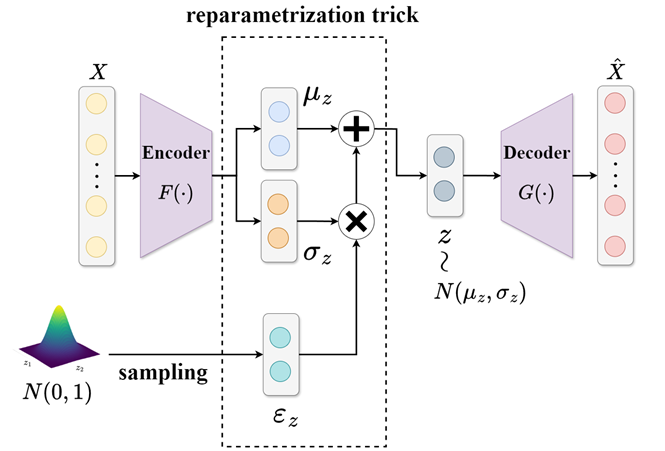

ÏÉùÏÑ±Ìòï Î™®Îç∏Í≥º Í≥µÏ†ï Î™®ÎãàÌÑ∞ÎßÅ
- Ï∞®Ïõê Ï∂ïÏÜå
  - PCA, VAE ÌòïÌÉúÏùò ÏÉùÏÑ±Ìòï Î™®Îç∏ÏùÄ Îç∞Ïù¥ÌÑ∞ Ï∞®Ïõê Ï∂ïÏÜåÎ•º Ìï† Ïàò ÏûàÏùå
  - Îî∞ÎùºÏÑú Í≥†Ï∞®Ïõê Í≥µÏ†ï Îç∞Ïù¥ÌÑ∞Î•º Ï≤òÎ¶¨Ìï† Ïàò ÏûàÏùå
  - Í≥†Ï∞®Ïõê Îç∞Ïù¥ÌÑ∞Ïùò ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ (Î∂ÑÌè¨, Ï†ïÎ≥¥)Î•º Î≥¥Ï°¥ÌïòÎ©¥ÏÑú Îç∞Ïù¥ÌÑ∞Ïùò ÌäπÏÑ±ÏùÑ ÌååÏïÖÌï† Ïàò ÏûàÏùå
  - ÏàòÏ≤ú Ï∞®ÏõêÏùò Îç∞Ïù¥ÌÑ∞Î•º 3Ï∞®Ïõê Ïù¥ÎÇ¥Î°ú Ï∂ïÏÜåÌïòÏó¨ ÏãúÍ∞ÅÌôî Ìï®ÏúºÎ°úÏç® Ïö¥Ï†ÑÏûêÍ∞Ä Ïù¥ÏÉÅ Ïú†Î¨¥Î•º ÏâΩÍ≤å ÌåêÎ≥ÑÌï† Ïàò ÏûàÍ≤å Ìï¥Ï§å
- Î∂ÄÎ∂Ñ Í≥µÍ∞Ñ Î∂ÑÎ¶¨
  - Í¥ÄÏ∏° Í≥µÍ∞ÑÏùÑ Í≥µÏ†ïÏùò Ìä∏Î†åÎìúÏôÄ ÎÖ∏Ïù¥Ï¶àÎ•º ÎÇòÌÉÄÎÇ¥Îäî Î∂ÄÎ∂ÑÍ≥µÍ∞ÑÏúºÎ°ú Î∂ÑÎ¶¨Ìï† Ïàò ÏûàÏùå
  - Ïù¥ÏÉÅÏùò ÏõêÏù∏ Î≥ÄÏàòÎ•º ÏâΩÍ≤å Í∑úÎ™ÖÌï† Ïàò ÏûàÏùå
  - Ïù¥ÏÉÅÏùÄ Ìä∏Î†åÎìú ÌòπÏùÄ ÎÖ∏Ïù¥Ï¶à ÎëòÏ§ë ÌïòÎÇòÏóêÎßå ÏòÅÌñ•ÏùÑ Ï£ºÎäî Í≤ΩÏö∞Í∞Ä ÎßéÏùå

Variational Autoencoder (VAE)
- Autoencoder (AE)
  - AEÎäî ÎπÑÏßÄÎèÑÌïôÏäµ Í∏∞Î≤ïÏù¥Î©∞, Îç∞Ïù¥ÌÑ∞Î•º Ï∂ïÏÜåÌïú ÌõÑ ÏõêÎûòÏùò ÌòïÌÉúÎ°ú Ïû¨Íµ¨Ï∂ïÌïòÎäî Íµ¨Ï°∞Î•º Í∞ÄÏßÄÍ≥† ÏûàÎã§.
  - ÎπÑÏÑ†Ìòï Ï∞®ÏõêÏ∂ïÏÜå Í∏∞Î≤ïÏúºÎ°ú, ÏÑ†Ìòï Ï∞®ÏõêÏ∂ïÏÜåÏùò PCAÏùò ÏùºÎ∞òÌôî ÌòïÌÉúÎ°ú Î≥º Ïàò ÏûàÎã§.
- Variational AE (VAE)
  - AE + Î≤†Ïù¥ÏßÄÏïà Ï∂îÎ°†: AEÏùò ÎπÑÏÑ†Ìòï Îç∞Ïù¥ÌÑ∞ Ï∞®ÏõêÏ∂ïÏÜåÏùò Í∏∞Îä•ÏùÑ Ìï®Í≥º ÎèôÏãúÏóê Îç∞Ïù¥ÌÑ∞Ïùò ÌôïÎ•†Î∂ÑÌè¨Î•º Í≥†Î†§Ìï† Ïàò ÏûàÎäî ÎπÑÏßÄÎèÑÌïôÏäµ Í∏∞Î≤ï
  - Î≤†Ïù¥ÏßÄÏïà Ï∂îÎ°†ÏùÑ ÏúÑÌïú Î≥ÄÎ∂Ñ Ï∂îÎ°† (Variational inference)ÏùÑ ÏÇ¨Ïö©
  - VAEÎ•º ÏÇ¨Ïö©Ìïú Ïù¥ÏÉÅÌÉêÏßÄ: Hotelling's T2, Q (or SPE) statistics ÏÇ¨Ïö©

Îâ¥Îü¥ÎÑ∑ (`VAE`)
- Encoder: ÏûÖÎ†• ‚Üí 32 ‚Üí 16 ‚Üí Ïû†Ïû¨ ÌèâÍ∑†(mu), Î°úÍ∑∏Î∂ÑÏÇ∞(logvar)
- Reparameterization: $z = \mu + \sigma¬∑\varepsilon, \varepsilon \sim \mathcal{N}(0, I)$
- Decoder: Ïû†Ïû¨Î≤°ÌÑ∞ z ‚Üí 16 ‚Üí 32 ‚Üí ÏûÖÎ†• Ï∞®Ïõê Î≥µÏõê

ÏÜêÏã§ Ìï®Ïàò (`vae_loss_mse_kld`)

\begin{equation*}
\begin{split}
L(\theta, \phi; x) &= \underbrace{-\mathbb{E}_{q_{\phi}(z|x)}\left[ \log p_{\theta}(x'|z) \right]}_{\textup{Ïû¨Íµ¨Ï∂ï Ïò§Ï∞®}} + \underbrace{D_{KL}\left( q_{\phi}(z|x) \Vert p(z) \right)}_{\textup{ÏÇ¨Ï†Ñ ÌôïÎ•† Ìé∏Ï∞®}} \\
&= \underbrace{\frac{1}{N} \sum_{i=1}^{N} \|x_i - x'_i\|^2}_{\textup{Ïû¨Íµ¨Ï∂ï Ïò§Ï∞®}} + \underbrace{\dfrac{1}{2}\sum_{j=1}^{m} \left( \sigma_{z_j}^2 + \mu_{z_j}^2  - \ln(\sigma_{z_j}^2) - 1\right)}_{\textup{ÏÇ¨Ï†Ñ ÌôïÎ•† Ìé∏Ï∞®}}
\end{split}
\end{equation*}

- Ïû¨Íµ¨Ï∂ï Ïò§Ï∞®Îäî Ïã§Ï†ú ÏΩîÎìúÏóêÏÑúÎäî Îã®ÏàúÌûà ÏûÖÎ†•Îç∞Ïù¥ÌÑ∞ÏôÄ Ï∂úÎ†•Îç∞Ïù¥ÌÑ∞Ïùò MSEÎ°ú Íµ¨ÌòÑ
- ÏÇ¨Ï†Ñ ÌôïÎ•† Ìé∏Ï∞®Îäî Kullback-Leibler (KL) Î∞úÏÇ∞ÏúºÎ°ú Ï∏°Ï†ïÌïòÎ©∞, Ïû†Ïû¨Î≥ÄÏàò $ùëç$Í∞Ä ÏÇ¨Ï†Ñ Ïû†Ïû¨ Î∂ÑÌè¨ (ÌëúÏ§Ä Ï†ïÍ∑ú Î∂ÑÌè¨) $ùëù(ùëç)$Î•º Îî∞Î•¥ÎèÑÎ°ù Ïú†ÎèÑÌïòÎäî Ïó≠Ìï†ÏùÑ ÌïúÎã§. $ùëç$ Ïùò Î∂ÑÌè¨Í∞Ä Ï†ïÍ∑úÎ∂ÑÌè¨Î•º Îî∞Î•¥Í≤å ÎêòÎ©¥ Hotelling's T2 ÌÜµÍ≥ÑÎüâÏùÑ ÏÇ¨Ïö©Ìï† Ïàò ÏûàÍ≤å ÎêúÎã§.

(Ï∞∏Í≥†) VAE loss Ïú†ÎèÑ
\begin{equation*}
\begin{split}
\ln p_{\theta}(D) &= \mathbb{E}_{q_{\phi}(z|x)}\left[ \ln p_{\theta}(x) \right] \\
&= \mathbb{E}_{q_{\phi}(z|x)}\left[ \ln \dfrac{p_{\theta}(x, z)}{p_{\theta}(z|x)}  \right] \\
&= \mathbb{E}_{q_{\phi}(z|x)}\left[ \ln \dfrac{p_{\theta}(x, z)q_{\phi}(z|x)}{q_{\phi}(z|x)p_{\theta}(z|x)}  \right] \\
&= \mathbb{E}_{q_{\phi}(z|x)}\left[ \ln \dfrac{p_{\theta}(x, z)}{q_{\phi}(z|x)}  \right] +  \mathbb{E}_{q_{\phi}(z|x)}\left[ \ln \dfrac{q_{\phi}(z|x)}{p_{\theta}(z|x)}  \right] \\
&=\underbrace{\mathbb{E}_{q_{\phi}(z|x)}\left[ \ln \dfrac{p_{\theta}(x, z)}{q_{\phi}(z|x)}  \right]}_{\textup{ELBO } \uparrow} +  \underbrace{D_{KL}\left( q_{\phi}(z|x) \Vert p_{\theta}(z|x) \right)}_{\textup{Objective } \downarrow}
\end{split}
\end{equation*}

We aim to minimize the objective by maximizing the ELBO (evidence lower bound).
\begin{equation*}
\begin{split}
\max \underbrace{\mathbb{E}_{q_{\phi}(z|x)}\left[ \ln \dfrac{p_{\theta}(x, z)}{q_{\phi}(z|x)}  \right]}_{\textup{ELBO } \uparrow} &= \int \ln \dfrac{p_{\theta}(x|z)p(z)}{q_{\phi}(z|x)}q_{\phi}(z|x)dz \\
&= \underbrace{\mathbb{E}_{q_{\phi}(z|x)}\left[ p_{\theta}(x|z)\right]}_{\textup{Reconstruction term}} -  \underbrace{D_{KL}\left( q_{\phi}(z|x) \Vert p(z)\right)}_{\textup{Prior fitting term}} \\
\min \mathrm{ELBO} &= -\mathbb{E}_{q_{\phi}(z|x)}\left[ p_{\theta}(x|z)\right] + D_{KL}\left( q_{\phi}(z|x) \Vert p(z)\right)
\end{split}
\end{equation*}

For an normal Gaussian case

\begin{equation*}
\begin{split}
D_{KL}\left( q_{\phi}(z|x) \Vert \mathcal{N}(0, I)\right) = \dfrac{1}{2} \sum_{j=1}^{m} \left( \sigma_{z_j}^2 + \mu_{z_j}^2  - \ln(\sigma_{z_j}^2) - 1\right)
\end{split}
\end{equation*}

In [ ]:
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super().__init__()
        # Encoder
        self.fc1 = nn.Linear(input_dim, input_dim)
        self.fc2 = nn.Linear(input_dim, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc_mu = nn.Linear(16, latent_dim)
        self.fc_logvar = nn.Linear(16, latent_dim)
        # Decoder
        self.fc4 = nn.Linear(latent_dim, 16)
        self.fc5 = nn.Linear(16, 32)
        self.fc6 = nn.Linear(32, input_dim)  # linear Ï∂úÎ†•

    def encode(self, x):
        h = F.leaky_relu(self.fc1(x))
        h = F.leaky_relu(self.fc2(h))
        h = F.leaky_relu(self.fc3(h))
        mu = F.leaky_relu(self.fc_mu(h))
        logvar = F.leaky_relu(self.fc_logvar(h)) # varianceÎ•º Ìï≠ÏÉÅ ÏñëÏàòÎ°ú ÎßåÎì§Í∏∞ ÏúÑÌï¥ ÏÇ¨Ïö©
        return mu, logvar

    def reparameterize(self, mu, logvar): # backpropagationÏùÑ ÏúÑÌï¥ ÏÇ¨Ïö©, encodeÏóêÏÑú Í≥ÑÏÇ∞Îêú ÌèâÍ∑†Í≥º Î∂ÑÏÇ∞ÏúºÎ°ú Î∂ÄÌÑ∞ Ìï¥Îãπ Î∂ÑÌè¨Ïùò ÏÉòÌîåÎßÅÏùÑ Ìï¥ÏôÄÏÑú decodeÏóê ÎÑ£Îäî Í≥ºÏ†ïÏûÑÏûÑ
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + std * eps

    def decode(self, z, input_dim):
        h = F.leaky_relu(self.fc4(z))
        h = F.leaky_relu(self.fc5(h))
        out = self.fc6(h)
        return out

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z, x.shape[1])
        return recon, mu, logvar, z

def vae_loss_mse_kld(x, recon, mu, logvar, input_dim):
    # Ïû¨Íµ¨Ï∂ï Ïò§Ï∞®: mean(square)*input_dim
    recon_loss = torch.mean((x - recon) ** 2) * input_dim
    # KL: -0.5 * sum(1 + logvar - mu^2 - exp(logvar))
    # Î∞∞ÏπòÎãπ ÌèâÍ∑†
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - torch.exp(logvar), dim=-1)
    kl = torch.mean(kl)
    return recon_loss + kl, recon_loss.detach(), kl.detach()



Ï°∞Í∏∞ Ï¢ÖÎ£å (`EarlyStoppingTorch`)

Í≤ÄÏ¶ù ÏßÄÌëú(val_loss Îì±)Î•º Î™®ÎãàÌÑ∞ÎßÅÌïòÏó¨ ÏùºÏ†ï Í∏∞Í∞Ñ(patience) ÎèôÏïà Í∞úÏÑ†Ïù¥ ÏóÜÏúºÎ©¥ ÌïôÏäµÏùÑ Ï§ëÎã®ÌïòÍ≥†, Í∞ÄÏû• Ï¢ãÏùÄ Î™®Îç∏ ÌååÎùºÎØ∏ÌÑ∞Î•º Î≥µÏõê
- monitor: Î™®ÎãàÌÑ∞ÎßÅÌï† ÏßÄÌëúÎ™Ö (Í∏∞Î≥∏ "val_loss")
- patience: Í∞úÏÑ†Ïù¥ ÏóÜÏùÑ Îïå ÌóàÏö©ÌïòÎäî ÏµúÎåÄ epoch Ïàò (Í∏∞Î≥∏ 20)
- mode: "min"Ïù¥Î©¥ ÏßÄÌëúÍ∞Ä ÏûëÏïÑÏßà Îïå Ìñ•ÏÉÅ, "max"Ïù¥Î©¥ Ïª§Ïßà Îïå Ìñ•ÏÉÅ

ÏàúÏÑú
1. step(current, model): ÌòÑÏû¨ ÏßÄÌëúÏôÄ best ÎπÑÍµê
   - Í∞úÏÑ† Ïãú: best Í∞±Ïã†, wait=0, Î™®Îç∏ ÏÉÅÌÉú Ï†ÄÏû•
   - Í∞úÏÑ† ÏóÜÏùÑ Ïãú: wait+1, patience Ï¥àÍ≥º Ïó¨Î∂Ä Î∞òÌôò
2. restore_best(model): Ï†ÄÏû•Îêú best ÏÉÅÌÉúÎ°ú Î™®Îç∏ Î≥µÏõê


In [7]:
class EarlyStoppingTorch:
    def __init__(self, monitor="val_loss", patience=20, mode="min"):
        self.monitor = monitor
        self.patience = patience
        self.mode = mode
        self.best = math.inf if mode == "min" else -math.inf
        self.wait = 0
        self.best_state = None

    def step(self, current, model):
        improved = (current < self.best) if self.mode == "min" else (current > self.best)
        if improved:
            self.best = current
            self.wait = 0
            self.best_state = copy.deepcopy(model.state_dict())
            return False  # not stop
        else:
            self.wait += 1
            return self.wait > self.patience

    def restore_best(self, model):
        if self.best_state is not None:
            model.load_state_dict(self.best_state)



Îç∞Ïù¥ÌÑ∞ Î°úÎìú Î∞è Ï†ÑÏ≤òÎ¶¨

VAE ÌïôÏäµÏóê ÏÇ¨Ïö©Ìï† Tennessee Eastman Process Îç∞Ïù¥ÌÑ∞Î•º Î∂àÎü¨Ïò§Í≥† ÌëúÏ§ÄÌôîÎ•º ÏàòÌñâ. Í∑∏ ÌõÑ train, test setÏúºÎ°ú Î∂ÑÌï†ÌïòÏó¨ PyTorch DataLoaderÎ°ú Î≥ÄÌôò

1. CSV ÌååÏùº Î°úÎìú (`train_test.csv`)
2. ÌëúÏ§ÄÌôî: `StandardScaler`Î°ú ÌèâÍ∑† 0, ÌëúÏ§ÄÌé∏Ï∞® 1 Ïä§ÏºÄÏùº Î≥ÄÌôò
3. Train, test set Î∂ÑÌï† (test_size=0.2, shuffle)
4. TensorDatasetÏúºÎ°ú Î≥ÄÌôò ÌõÑ DataLoader ÏÉùÏÑ± (Î∞∞Ïπò ÌÅ¨Í∏∞ 32)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# 1) Îç∞Ïù¥ÌÑ∞ Î°úÎìú
data_train = pd.read_csv('VAEcodes/data/train_test.csv', index_col=0)
print(data_train.head())

# 2) ÌëúÏ§ÄÌôî
scaler = StandardScaler()
scaler.fit(data_train)
data_train_scaled = scaler.transform(data_train).astype("float32")

# 3) ÌïôÏäµ/Í≤ÄÏ¶ù Î∂ÑÎ¶¨
x_train, x_val = train_test_split(data_train_scaled, test_size=0.2, shuffle=True, random_state=58)
x_total = data_train_scaled

# 4) TensorDataset + DataLoader
bs = 32
train_ds = TensorDataset(torch.from_numpy(x_train))
val_ds   = TensorDataset(torch.from_numpy(x_val))
train_loader = DataLoader(train_ds, batch_size=bs, shuffle=True, drop_last=False)
val_loader   = DataLoader(val_ds, batch_size=bs, shuffle=False, drop_last=False)


Device: cuda
         0       1       2       3       4       5       6       7       8  \
0  0.24889  3702.3  4502.7  9.4170  26.996  42.183  2705.2  75.173  120.40   
1  0.24904  3666.2  4526.0  9.2682  26.710  42.332  2705.5  74.411  120.41   
2  0.25034  3673.3  4501.3  9.4212  26.842  42.360  2705.3  75.125  120.41   
3  0.25109  3657.8  4497.8  9.3792  26.528  41.982  2707.3  73.992  120.38   
4  0.24563  3698.0  4537.4  9.3746  26.736  42.354  2705.3  75.283  120.42   

         9  ...      42      43      44      45      46      47      48  \
0  0.33611  ...  54.059  24.804  63.269  21.950  40.188  39.461  47.000   
1  0.33676  ...  53.781  24.790  62.171  22.239  40.108  43.710  46.128   
2  0.33739  ...  54.075  24.669  61.585  22.191  40.030  39.480  44.121   
3  0.33664  ...  54.117  24.595  61.561  21.959  40.121  32.848  45.858   
4  0.32521  ...  53.906  24.451  61.388  22.271  39.538  36.682  45.753   

       49      50      51  
0  47.594  41.384  18.905  
1  47.508  

VAE Î™®Îç∏ ÏÑ†Ïñ∏ Î∞è ÌïôÏäµ

VAEÎ•º Ï†ïÏùòÌïòÍ≥† ÌïôÏäµ, Í≤ÄÏ¶ù Î£®ÌîÑÎ•º Ïã§ÌñâÌïòÏó¨ ÏµúÏ†ÅÏùò Î™®Îç∏ ÌååÎùºÎØ∏ÌÑ∞Î•º Ï†ÄÏû•

ÏàúÏÑú
1. VAE Î™®Îç∏ ÏÉùÏÑ± Î∞è Adam ÏòµÌã∞ÎßàÏù¥Ï†Ä ÏÑ§Ï†ï
2. EarlyStoppingTorchÎ°ú Í≤ÄÏ¶ù ÏÜêÏã§ Î™®ÎãàÌÑ∞ÎßÅ
3. run_epoch Ìï®Ïàò
   - train Î™®Îìú: Ïó≠Ï†ÑÌååÏôÄ ÌååÎùºÎØ∏ÌÑ∞ ÏóÖÎç∞Ïù¥Ìä∏ ÏàòÌñâ
   - eval Î™®Îìú: ÏàúÏ†ÑÌååÎßå ÏàòÌñâ, ÏÜêÏã§ Í∏∞Î°ù
4. ÌïôÏäµ Î£®ÌîÑ
   - Í∞Å epochÎßàÎã§ ÌïôÏäµ/Í≤ÄÏ¶ù ÏÜêÏã§ Í≥ÑÏÇ∞
   - ÏÜêÏã§ Í∏∞Î°ù(history) ÏóÖÎç∞Ïù¥Ìä∏
   - Ï°∞Í∏∞ Ï¢ÖÎ£å Ï°∞Í±¥ ÌôïÏù∏
5. ÌïôÏäµ Ï¢ÖÎ£å ÌõÑ
   - best Î™®Îç∏ ÌååÎùºÎØ∏ÌÑ∞ Î≥µÏõê
   - torch.saveÎ°ú Î™®Îç∏Í≥º Ï£ºÏöî ÏÑ§Ï†ï Ï†ÄÏû•

In [9]:
# ======================
# VAE Î™®Îç∏ ÏÑ†Ïñ∏/ÌïôÏäµ
# ======================
input_dim = x_train.shape[1]
latent_dim = 8
lr = 1e-3
epochs = 100
patience = 20

vae = VAE(input_dim, latent_dim).to(device)
optim = torch.optim.Adam(vae.parameters(), lr=lr)
stopper = EarlyStoppingTorch(monitor="val_loss", patience=patience, mode="min")

def run_epoch(loader, train_mode=True):
    if train_mode:
        vae.train()
    else:
        vae.eval()
    total_loss, total_n = 0.0, 0
    with torch.set_grad_enabled(train_mode):
        for (xb,) in loader:
            xb = xb.to(device)
            recon, mu, logvar, z = vae(xb)
            loss, _, _ = vae_loss_mse_kld(xb, recon, mu, logvar, input_dim)
            if train_mode:
                optim.zero_grad()
                loss.backward()
                optim.step()
            total_loss += loss.item() * xb.size(0)
            total_n += xb.size(0)
    return total_loss / max(1, total_n)

history = {"train_loss": [], "val_loss": []}
best_path = "VAEcodes/results/VAE_torch.pt"

for epoch in range(1, epochs + 1):
    tr = run_epoch(train_loader, train_mode=True)
    vl = run_epoch(val_loader, train_mode=False)
    history["train_loss"].append(tr)
    history["val_loss"].append(vl)
    print(f"[{epoch:03d}] train={tr:.6f}  val={vl:.6f}")

    if stopper.step(vl, vae):
        print(f"Early stopping triggered at epoch {epoch}.")
        break

stopper.restore_best(vae)
torch.save({
    "model_state": vae.state_dict(),
    "input_dim": input_dim,
    "latent_dim": latent_dim,
    "scaler": scaler  # ÌïÑÏöîÏãú joblibÎ°ú Îî∞Î°ú Ï†ÄÏû•Ìï¥ÎèÑ Îê®
}, best_path)
print(f"Saved: {best_path}")



[001] train=52.969022  val=52.709614
[002] train=52.461154  val=52.466611
[003] train=52.258945  val=52.323712
[004] train=52.163392  val=52.366163
[005] train=52.143667  val=52.230225
[006] train=52.103017  val=52.269651
[007] train=52.089697  val=52.190108
[008] train=52.063587  val=52.124535
[009] train=52.030509  val=52.093360
[010] train=51.977157  val=52.160831
[011] train=51.965329  val=52.025501
[012] train=51.871884  val=52.114038
[013] train=51.487262  val=51.412015
[014] train=50.754830  val=51.098248
[015] train=50.002786  val=49.656962
[016] train=49.032193  val=49.972587
[017] train=48.842917  val=49.324691
[018] train=48.796102  val=49.241991
[019] train=48.544591  val=49.211625
[020] train=48.458774  val=49.025379
[021] train=48.384473  val=48.640330
[022] train=48.215111  val=48.894208
[023] train=47.923303  val=48.163482
[024] train=47.879741  val=48.681250
[025] train=47.912741  val=48.359500
[026] train=47.982215  val=47.885736
[027] train=48.056477  val=47.484999
[

Ïû†Ïû¨Í≥µÍ∞Ñ Ï∂îÏ∂ú Î∞è ÏãúÍ∞ÅÌôî

ÌïôÏäµÎêú VAEÏùò Ïù∏ÏΩîÎçîÎ•º ÌÜµÌï¥ Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞Ïùò Ïû†Ïû¨Î≤°ÌÑ∞Î•º Ï∂îÏ∂úÌïòÍ≥†, Î≥ÄÏàò Í∞Ñ Í¥ÄÍ≥ÑÎ•º ÏãúÍ∞ÅÌôîÌïòÏó¨ Î∂ÑÌè¨ Î∞è ÏÉÅÍ¥Ä Íµ¨Ï°∞Î•º ÌååÏïÖ

ÏàúÏÑú
1. VAEÎ•º ÌèâÍ∞Ä Î™®ÎìúÎ°ú Ï†ÑÌôò (`vae.eval()`)
2. Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞ `x_total`ÏùÑ ÌÖêÏÑúÎ°ú Î≥ÄÌôò ÌõÑ Î™®Îç∏Ïóê ÏûÖÎ†•
3. Ï∂úÎ†• Ï§ë Ïû†Ïû¨Î≥ÄÏàò zÎßå Ï∂îÏ∂úÌï¥ CPUÎ°ú Ïù¥Îèô Î∞è numpy Î∞∞Ïó¥ Î≥ÄÌôò
4. Ïû†Ïû¨Î≥ÄÏàòÎ•º DataFrameÏúºÎ°ú Î≥ÄÌôò
5. seaborn `pairplot`ÏúºÎ°ú Ïû†Ïû¨Î≥ÄÏàò Í∞Ñ ÏÇ∞Ï†êÎèÑ/Î∂ÑÌè¨ ÏãúÍ∞ÅÌôî

<Figure size 2000x2000 with 0 Axes>

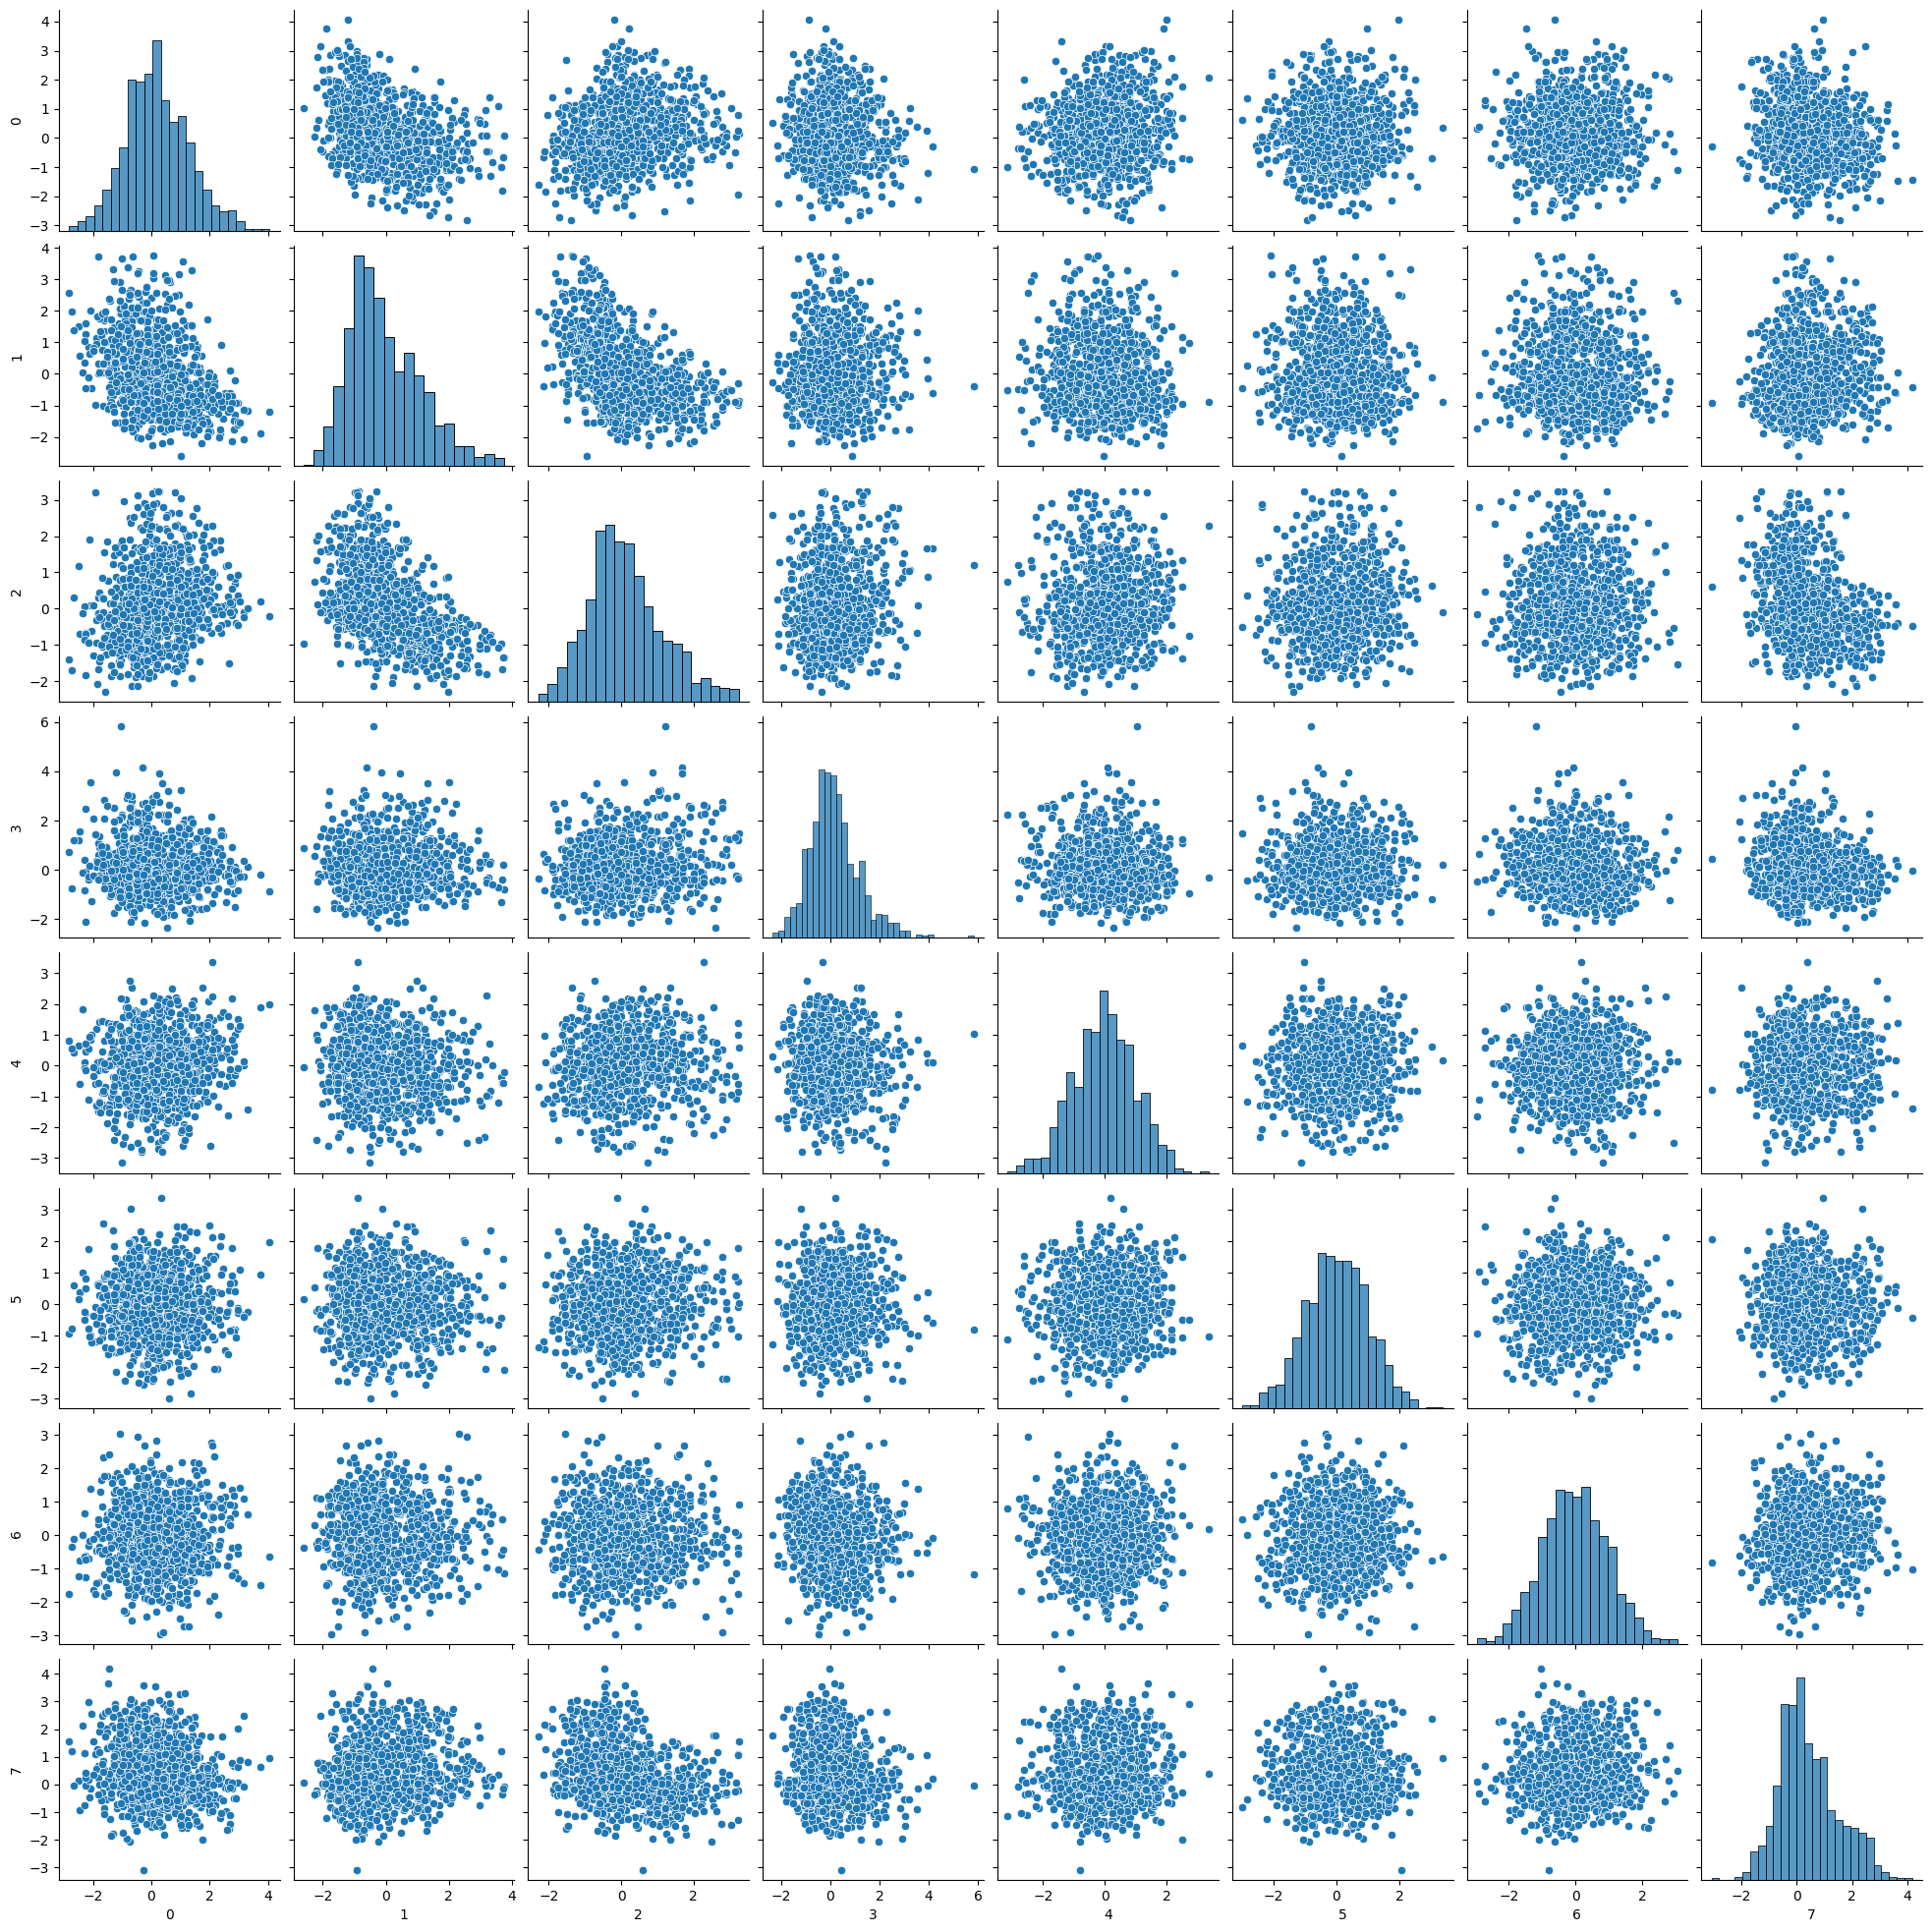

In [ ]:
vae.eval() # ÎåÄÍ∞ÅÌñâÎ†¨Ïù¥ Í∞ÄÏö∞ÏãúÏïà Î∂ÑÌè¨Î•º Ïûò Îî∞Î•¥Í≥† Îã§Î•∏ Î≥ÄÏàòÏôÄÎèÑ ÏõêÌòï Î∂ÑÏÇ∞ plotÏù¥ ÎÇòÏò¥ -> Ï†ïÍ∑úÌôîÎêú Î∂ÑÌè¨Î•º Ïûò Îî∞Î•∏Îã§Î•∏Îã§
with torch.no_grad():
    X_total_t = torch.from_numpy(x_total).to(device)
    _, _, _, Z_total_t = vae(X_total_t)
    Z_total = Z_total_t.cpu().numpy()

latent_df = pd.DataFrame(Z_total)
plt.figure(figsize=(20, 20))
sns.pairplot(latent_df)
plt.show()

SPE Î∞è Hotelling's T2 ÏûÑÍ≥ÑÍ∞í(UCL) Í≥ÑÏÇ∞ Î∞è ÏãúÍ∞ÅÌôî

ÌïôÏäµ Îç∞Ïù¥ÌÑ∞ÏóêÏÑú Squared Prediction Error(SPE)ÏôÄ Hotelling's T2 Í∞íÏùÑ Í≥ÑÏÇ∞ÌïòÍ≥†, KDE Í∏∞Î∞ò ÏÉÅÏúÑ 95% ÏûÑÍ≥ÑÍ∞í(UCL)ÏùÑ ÏÇ∞Ï∂úÌïòÏó¨ Í∏∞Ï§ÄÏÑ†ÏúºÎ°ú ÏãúÍ∞ÅÌôîÌïúÎã§.

ÏàúÏÑú
1. SPE Í≥ÑÏÇ∞
   - Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞ Ïû¨Íµ¨ÏÑ± ÌõÑ (ÏûÖÎ†• - Ïû¨Íµ¨ÏÑ±)Ïùò Ï†úÍ≥±Ìï©ÏùÑ ÏÉòÌîåÎ≥ÑÎ°ú Í≥ÑÏÇ∞
   - `compute_KDE`Î°ú SPEÏùò 95% UCL Í≥ÑÏÇ∞
   - ÏãúÍ≥ÑÏó¥Î°ú plot ÌõÑ UCL ÌëúÏãú
2. Hotelling's T¬≤ Í≥ÑÏÇ∞
   - Ïû†Ïû¨Î≥ÄÏàò ZÏùò ÌèâÍ∑†, Í≥µÎ∂ÑÏÇ∞ Ïó≠ÌñâÎ†¨ Í≥ÑÏÇ∞
   - `compute_T2`Î°ú Í∞Å ÏÉòÌîåÏùò T2 ÏÇ∞Ï∂ú
   - `compute_KDE`Î°ú T2Ïùò 95% UCL Í≥ÑÏÇ∞
   - ÏãúÍ≥ÑÏó¥Î°ú plot ÌõÑ UCL ÌëúÏãú

SPE UCL: 60.195721954370946


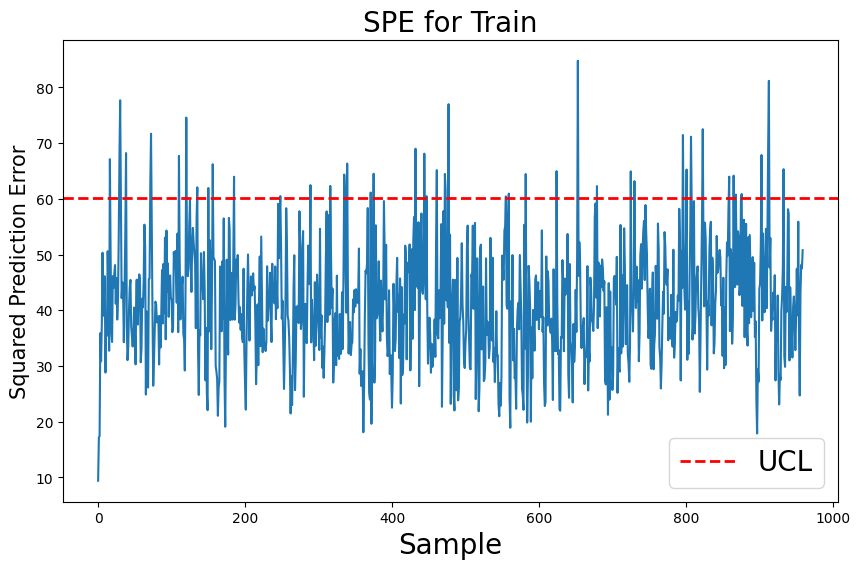

T2 UCL: 15.718387335484566


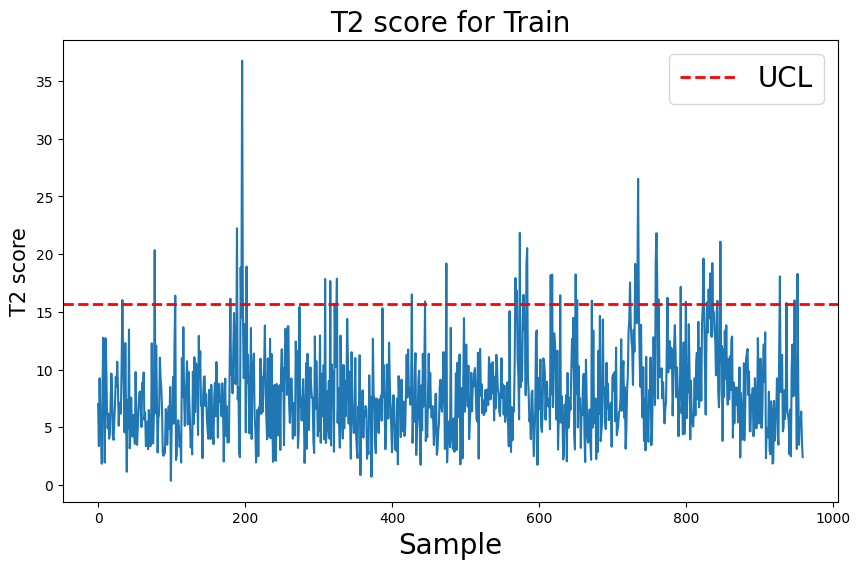

In [11]:
# SPE UCL
with torch.no_grad():
    recon_total, _, _, _ = vae(torch.from_numpy(x_total).to(device))
    recon_total = recon_total.cpu().numpy()
total_recon = np.sum((x_total - recon_total) ** 2, axis=1)  # squared prediction error
UCL_SPE = compute_KDE(total_recon.reshape(-1, 1), alpha=95)
print(f"SPE UCL: {UCL_SPE}")

plt.figure(figsize=(10, 6))
plt.plot(total_recon)
plt.axhline(y=UCL_SPE, color='r', linestyle='--', label='UCL', linewidth=2)
plt.xlabel('Sample', fontsize=20)
plt.ylabel('Squared Prediction Error', fontsize=15)
plt.title('SPE for Train', fontsize=20)
plt.legend(fontsize=20)
plt.savefig('VAEcodes/results/SPE for Train.png')
plt.show()

# Hotelling T¬≤ UCL
S, S_inv, mu = compute_cov_and_inv(Z_total)
T2_total = compute_T2(Z_total, mu, S_inv)
UCL_T2 = compute_KDE(T2_total.reshape(-1, 1), alpha=95)
print(f"T2 UCL: {UCL_T2}")

plt.figure(figsize=(10, 6))
plt.plot(T2_total)
plt.axhline(y=UCL_T2, color='r', linestyle='--', label='UCL', linewidth=2)
plt.xlabel('Sample', fontsize=20)
plt.ylabel('T2 score', fontsize=15)
plt.title('T2 score for Train', fontsize=20)
plt.legend(fontsize=20)
plt.savefig('VAEcodes/results/T2 score for Train.png')
plt.show()

Fault detection ÏÑ±Îä• ÌèâÍ∞Ä

ÌïôÏäµÎêú VAE Î™®Îç∏Í≥º UCLÏùÑ ÏÇ¨Ïö©ÌïòÏó¨ Í∞Å Fault ÏãúÎÇòÎ¶¨Ïò§(1~21)Ïùò SPE Î∞è T2 Í∏∞Î∞ò fault detection ÏÑ±Îä• ÌèâÍ∞Ä

ÏàúÏÑú
1. Í∞Å Fault ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ Î∂àÎü¨Ïò§Í∏∞ Î∞è ÌëúÏ§ÄÌôî
2. VAEÎ°ú Ïû¨Íµ¨ÏÑ± Î∞è Ïû†Ïû¨Î≥ÄÏàò Ï∂îÏ∂ú
3. SPEÏôÄ T2 Í∞íÏùÑ Í≥ÑÏÇ∞
4. Fault Î∞úÏÉùÌïòÎäî 160Î≤àÏß∏ sample Ï†ÑÌõÑ Íµ¨Í∞Ñ Î∂ÑÎ¶¨
5. `compute_F1`Î°ú TP, FP, F1 score Í≥ÑÏÇ∞
6. FaultÎ≥Ñ SPE, T2 ÏãúÍ≥ÑÏó¥ Í∑∏ÎûòÌîÑ ÏÉùÏÑ± Î∞è Ï†ÄÏû•

In [ ]:
result = pd.DataFrame(columns=['Fault', 'FDR_SPE', 'FAR_SPE', 'F1_Score_SPE',
                               'FDR_T2',  'FAR_T2',  'F1_Score_T2'])

for i in range(1, 22):
    fn = f'VAEcodes/data/fault_{i}_test.csv'
    if not os.path.isfile(fn):
        print(f"Warning: Cannot find {fn} file")
        continue
    fault = pd.read_csv(fn, index_col=0).values.astype('float32')
    fault = scaler.transform(fault).astype('float32')

    with torch.no_grad():
        Xf = torch.from_numpy(fault).to(device)
        recon_f, _, _, Zf_t = vae(Xf)
        recon_f = recon_f.cpu().numpy()
        Zf = Zf_t.cpu().numpy()

    fault_SPE = np.sum((fault - recon_f) ** 2, axis=1)
    fault_T2  = compute_T2(Zf, mu, S_inv)

    # faultÎäî 160Î≤àÏß∏ ÏÉòÌîåÎ∂ÄÌÑ∞ Î∞úÏÉù
    no_fault_SPE = fault_SPE[:160]
    yes_fault_SPE = fault_SPE[160:]

    no_fault_T2 = fault_T2[:160]
    yes_fault_T2 = fault_T2[160:]

    TP_SPE, FP_SPE, F1_SPE = compute_F1(yes_fault_SPE, no_fault_SPE, UCL_SPE)
    TP_T2,  FP_T2,  F1_T2  = compute_F1(yes_fault_T2,  no_fault_T2,  UCL_T2)

    result.loc[len(result)] = [i, TP_SPE, FP_SPE, F1_SPE, TP_T2, FP_T2, F1_T2]

    # Plot
    fig, axs = plt.subplots(2, 1, figsize=(10, 12))
    axs[0].plot(fault_SPE, label='SPE')
    axs[0].axhline(y=UCL_SPE, color='r', linestyle='--', label='UCL', linewidth=2)
    axs[0].set_xlabel('Sample', fontsize=15)
    axs[0].set_ylabel('SPE', fontsize=15)
    axs[0].set_title(f'Fault {i} SPE', fontsize=20)
    axs[0].legend(fontsize=15)

    axs[1].plot(fault_T2, label='T2')
    axs[1].axhline(y=UCL_T2, color='r', linestyle='--', label='UCL', linewidth=2)
    axs[1].set_xlabel('Sample', fontsize=15)
    axs[1].set_ylabel('T2 Score', fontsize=15)
    axs[1].set_title(f'Fault {i} T2', fontsize=20)
    axs[1].legend(fontsize=15)

    plt.tight_layout()
    plt.savefig(f'VAEcodes/results/Fault{i}_SPE_T2.png')
    plt.close()

result.to_csv('VAEcodes/results/result.csv', index=False)
print("Saved: result.csv")

/home/sjbaek/miniforge3/envs/PSE_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/sjbaek/miniforge3/envs/PSE_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/sjbaek/miniforge3/envs/PSE_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/sjbaek/miniforge3/envs/PSE_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/sjbaek/miniforge3/envs/PSE_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid f

Saved: result.csv
